## Dataset

### Carregar Dataset

Este notebook usa o dataset X do Kaggle. O download é feito via kagglehub para garantir reprodutibilidade

In [2]:
import os
import kagglehub
import pandas as pd

path = kagglehub.dataset_download("uom190346a/sleep-health-and-lifestyle-dataset")

file_path = os.path.join(path, "Sleep_health_and_lifestyle_dataset.csv")
df = pd.read_csv(file_path)

Using Colab cache for faster access to the 'sleep-health-and-lifestyle-dataset' dataset.


In [3]:
df.head()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


In [4]:
df['Blood Pressure'].value_counts()

,count
Blood Pressure,
130/85,99
140/95,65
125/80,65
120/80,45
115/75,32
135/90,27
140/90,4
125/82,4
128/85,3


In [5]:
print(f"{df.shape} \n")
print(f"{df.dtypes} \n")
print(f"{df.isnull().sum()} \n")

(374, 13) 

Person ID                    int64
Gender                      object
Age                          int64
Occupation                  object
Sleep Duration             float64
Quality of Sleep             int64
Physical Activity Level      int64
Stress Level                 int64
BMI Category                object
Blood Pressure              object
Heart Rate                   int64
Daily Steps                  int64
Sleep Disorder              object
dtype: object 

Person ID                    0
Gender                       0
Age                          0
Occupation                   0
Sleep Duration               0
Quality of Sleep             0
Physical Activity Level      0
Stress Level                 0
BMI Category                 0
Blood Pressure               0
Heart Rate                   0
Daily Steps                  0
Sleep Disorder             219
dtype: int64 



### Validação de formato dos dados

Validamos o formato sistólica/diastólica antes de transformar em variáveis numéricas e gerar o rótulo alvo. Se houvesse valores fora do padrão, trataríamos separadamente (corrigir parsing, remover linhas ou imputar).

Após validação do formato da variável Blood Pressure via regex, verificou-se que todos os registros seguem o padrão numérico ‘sistólica/diastólica’, permitindo o parsing direto sem perda de informação.

In [6]:
import re

pattern = r'^\d+/\d+$'

invalid_bp = df[~df['Blood Pressure'].astype(str).str.match(pattern)]

print(f"Valores fora do padrão esperado: {len(invalid_bp)}")
invalid_bp['Blood Pressure'].value_counts().head(10)


Valores fora do padrão esperado: 0


,count
Blood Pressure,


### Construção do dataset base e definição do alvo clínico

Nesta etapa, realizamos o pré-processamento inicial do dataset com foco na
preparação do target de classificação multiclasse.

As principais transformações realizadas são:

- **Remoção de identificadores**  
  A coluna `Person ID` é descartada por não conter informação preditiva e
  representar apenas um identificador único.

- **Tratamento da variável `Sleep Disorder`**  
  Valores ausentes nessa coluna são interpretados como ausência de diagnóstico
  de distúrbio do sono, e portanto substituídos por `"No Disorder"`.
  Essa decisão assume que o dataset apenas reporta explicitamente os casos em que
  há um distúrbio diagnosticado, e que valores nulos não representam dados perdidos,
  mas sim a inexistência da condição.

- **Extração da pressão arterial sistólica e diastólica**  
  A coluna `Blood Pressure`, originalmente no formato textual `"sistólica/diastólica"`,
  é separada em duas variáveis numéricas (`Systolic` e `Diastolic`) para permitir
  análises quantitativas e a definição do alvo.

- **Definição do alvo multiclasse (`BP_Category`)**  
  Os estágios de pressão arterial são definidos com base em faixas clínicas
  amplamente utilizadas (Normal, Elevated, Hypertension Stage 1, 2 e 3),
  considerando valores de pressão sistólica e diastólica.
  Essa variável representa o **alvo principal do problema de classificação multiclasse**.

- **Criação de um rótulo auxiliar binário (`HighRisk`)**  
  É criada uma variável binária que indica indivíduos com risco elevado
  (`Hypertension_Stage1`, `Stage2` ou `Stage3`).  
  Essa variável é utilizada **apenas para análises exploratórias** e não constitui
  o alvo principal do modelo.

- **Remoção de colunas auxiliares**  
  Após a criação do alvo, as colunas intermediárias (`Blood Pressure`, `Systolic`,
  `Diastolic`) são removidas para evitar redundância e possível vazamento de informação.

Ao final, a função retorna um dataset limpo e estruturado, pronto para
análises exploratórias e etapas posteriores de engenharia de features e modelagem.


In [7]:
def base_dataset(df):

    df_base = df.copy()

    # Drop ID
    df_base = df_base.drop(columns=["Person ID"])

    # Sleep Disorder: ausência reportada
    df_base["Sleep Disorder"] = df_base["Sleep Disorder"].fillna("No Disorder")

    # Separar pressão sistólica e diastólica
    df_base[["Systolic", "Diastolic"]] = (
        df_base["Blood Pressure"]
        .str.split("/", expand=True)
        .astype(int)
    )

    def bp_category(row):
        sys = row["Systolic"]
        dia = row["Diastolic"]

        if sys >= 180 or dia >= 110:
            return "Hypertension_Stage3"

        elif (160 <= sys < 180) or (100 <= dia < 110):
            return "Hypertension_Stage2"

        elif (140 <= sys < 160) or (90 <= dia < 100):
            return "Hypertension_Stage1"

        elif (130 <= sys < 140) or (85 <= dia < 90):
            return "Elevated"

        else:
            return "Normal"

    df_base["BP_Category"] = df_base.apply(bp_category, axis=1)

    # Target binário
    df_base["HighRisk"] = df_base["BP_Category"].isin(
        [
            "Hypertension_Stage1",
            "Hypertension_Stage2",
            "Hypertension_Stage3"
        ]
    ).astype(int)

    # Remover colunas auxiliares
    df_base = df_base.drop(columns=["Blood Pressure", "Systolic", "Diastolic"])

    return df_base


In [8]:
df_clean = base_dataset(df)
df_clean["BP_Category"].value_counts()

,count
BP_Category,
Normal,163
Elevated,111
Hypertension_Stage1,100


## Análise de Classes do Dataset

Nesta seção, analisamos a **distribuição das classes do dataset**, considerando tanto
uma variável binária auxiliar (`HighRisk`) quanto o **alvo principal do projeto**,
a variável multiclasse `BP_Category`.

O objetivo é:
- Avaliar o **balanceamento das classes**
- Identificar possíveis vieses estruturais
- Antecipar impactos na etapa de modelagem e escolha de métricas

---

### Análise Inicial: Risco Binário de Hipertensão (`HighRisk`)

Inicialmente, avaliamos a variável binária `HighRisk`, que indica indivíduos
com estágios clínicos de hipertensão (Stage 1, 2 ou 3).

Essa análise fornece uma visão geral da **prevalência global de hipertensão**
no dataset e é útil para comparações exploratórias iniciais.



In [9]:
# Análise de balanceamento

df_clean["HighRisk"].value_counts(normalize=True)

,proportion
HighRisk,
0,0.73262
1,0.26738


Observa-se que aproximadamente **27% dos indivíduos** pertencem à classe de alto risco,
enquanto **73%** não apresentam hipertensão em estágios clínicos.
Embora exista desbalanceamento, ele é moderado e pode ser tratado com métricas adequadas
ou técnicas de reamostragem, caso necessário.

### Análise do Alvo Multiclasse (`BP_Category`)

Em seguida, analisamos a distribuição do **alvo principal do projeto**:
a variável `BP_Category`, que representa os diferentes estágios clínicos da pressão arterial.


In [10]:
# Distribuição das classes multiclasse
df_clean["BP_Category"].value_counts(normalize=True)


,proportion
BP_Category,
Normal,0.435829
Elevated,0.296791
Hypertension_Stage1,0.267380


Observa-se que, após o pré-processamento e a definição das categorias clínicas,
não há instâncias pertencentes aos estágios mais severos
(**Hypertension_Stage2** e **Hypertension_Stage3**).
Isso sugere que o dataset está concentrado em indivíduos com pressão arterial
normal, levemente elevada ou em estágio inicial de hipertensão.

Do ponto de vista de modelagem, esse cenário implica que:
- O problema multiclasse efetivo envolve **três classes**, e não cinco como
  inicialmente definidas.
- Não há desbalanceamento extremo entre as classes presentes, embora exista
  uma predominância da classe **Normal**.

Essa limitação na variedade de estágios deve ser considerada na interpretação
dos resultados e na generalização do modelo para populações com casos mais severos
de hipertensão.

### Distribuição da Categoria de IMC (`BMI Category`)

Além do alvo, analisamos a distribuição da variável `BMI Category`,
por sua relevância clínica e potencial associação com a pressão arterial.

A análise evidencia a coexistência das categorias **"Normal"** e **"Normal Weight"**,
que representam semanticamente o mesmo estado nutricional.

Manter essas categorias separadas pode induzir o modelo a aprender
uma distinção artificial entre indivíduos clinicamente equivalentes,
introduzindo ruído desnecessário no processo de aprendizagem.


In [11]:
df_clean["BMI Category"].value_counts()


,count
BMI Category,
Normal,195
Overweight,148
Normal Weight,21
Obese,10


### Unificação semântica das categorias de IMC

Com base nessa observação, optamos por **unificar as categorias "Normal Weight" e "Normal Weight"**
em uma única classe (`Normal`), garantindo maior coerência semântica da variável.

In [12]:
# Unificação semântica das categorias de IMC
df_clean["BMI Category"] = df_clean["BMI Category"].replace(
    {"Normal": "Normal Weight"}
)
df_clean["BMI Category"].value_counts()

,count
BMI Category,
Normal Weight,216
Overweight,148
Obese,10


## Dataset com features adicionais

Nesta etapa, realizamos a criação de features derivadas com o objetivo de capturar
relações não triviais entre variáveis já existentes no dataset.

Essas novas variáveis buscam representar interações entre fatores fisiológicos
e comportamentais, que podem não ser adequadamente modeladas quando consideradas
de forma isolada.


### Eficiência do Sono (`Sleep_Efficiency`)

A variável `Sleep_Efficiency` é definida como o produto entre:

- `Sleep Duration` (duração do sono)
- `Quality of Sleep` (qualidade percebida do sono)

Essa feature funciona como uma proxy de eficiência do sono, combinando quantidade
e qualidade em uma única medida.
A motivação é distinguir, por exemplo, indivíduos que dormem muitas horas com baixa
qualidade daqueles que dormem menos, porém com sono mais eficiente.


### Índice de Estresse Cardíaco (`Cardiac_Stress_Index`)

A variável `Cardiac_Stress_Index` é definida como o produto entre:

- `Stress Level`
- `Heart Rate`

Essa combinação busca representar um indicador agregado de estresse fisiológico,
assumindo que níveis elevados de estresse aliados a uma frequência cardíaca elevada
podem estar associados a maior sobrecarga cardiovascular.


### Considerações Metodológicas

As features criadas nesta etapa são **heurísticas**, não correspondendo a métricas
clínicas padronizadas.
Entretanto, elas permitem que o modelo explore interações entre variáveis
potencialmente relevantes para a classificação dos estágios de pressão arterial.

Após a criação dessas features, é importante:
- Avaliar suas distribuições e presença de outliers
- Verificar correlação com o alvo `BP_Category`
- Monitorar possíveis impactos na escala dos dados durante a modelagem

In [13]:
def features_dataset(df_clean):

    df_features = df_clean.copy()

    # Eficiência do sono (duração × qualidade)
    df_features["Sleep_Efficiency"] = (
        df_features["Sleep Duration"] * df_features["Quality of Sleep"]
    )

    # Índice de estresse cardíaco
    df_features["Cardiac_Stress_Index"] = (
        df_features["Stress Level"] * df_features["Heart Rate"]
    )

    return df_features

In [14]:
df_features = features_dataset(df_clean)
df_features[["Sleep_Efficiency", "Cardiac_Stress_Index"]].describe()

,Sleep_Efficiency,Cardiac_Stress_Index
count,374.000000,374.000000
mean,52.994652,382.748663
std,13.932198,141.466528
min,23.200000,195.000000
25%,37.950000,260.000000
50%,54.600000,350.000000
75%,61.600000,504.000000
max,76.500000,680.000000


A matriz de correlação de Spearman permite analisar relações monotônicas
entre as variáveis numéricas e a progressão dos estágios de hipertensão,
representada pela variável ordinal `BP_Category_Ordinal`.

Observa-se uma correlação positiva moderada entre `Age` e `BP_Category_Ordinal`,
indicando que o avanço da idade está associado ao aumento do estágio de hipertensão,
em concordância com expectativas clínicas.

A variável `Physical Activity Level` também apresenta correlação positiva
com o alvo, sugerindo que padrões específicos de atividade física podem estar
associados aos estágios de pressão arterial no dataset. No entanto, essa relação
deve ser interpretada com cautela, pois não implica causalidade e pode refletir
fatores de confusão.

Por outro lado, `Sleep Duration` e `Quality of Sleep` exibem correlações negativas
fracas a moderadas com o alvo, indicando que maior duração e melhor qualidade do sono
tendem a estar associadas a estágios menos severos de hipertensão.

Variáveis como `Stress Level`, `Heart Rate` e `Daily Steps` apresentam correlação
fraca com `BP_Category_Ordinal`, sugerindo que, isoladamente, podem não ser bons
preditores lineares do estágio de hipertensão, embora ainda possam contribuir em
modelos não lineares ou em interações com outras features.

É importante ressaltar que essa análise utiliza uma codificação ordinal do alvo
e a correlação de Spearman, o que representa uma aproximação exploratória.
Assim, os resultados devem ser interpretados como indícios de associação,
não como relações causais diretas.


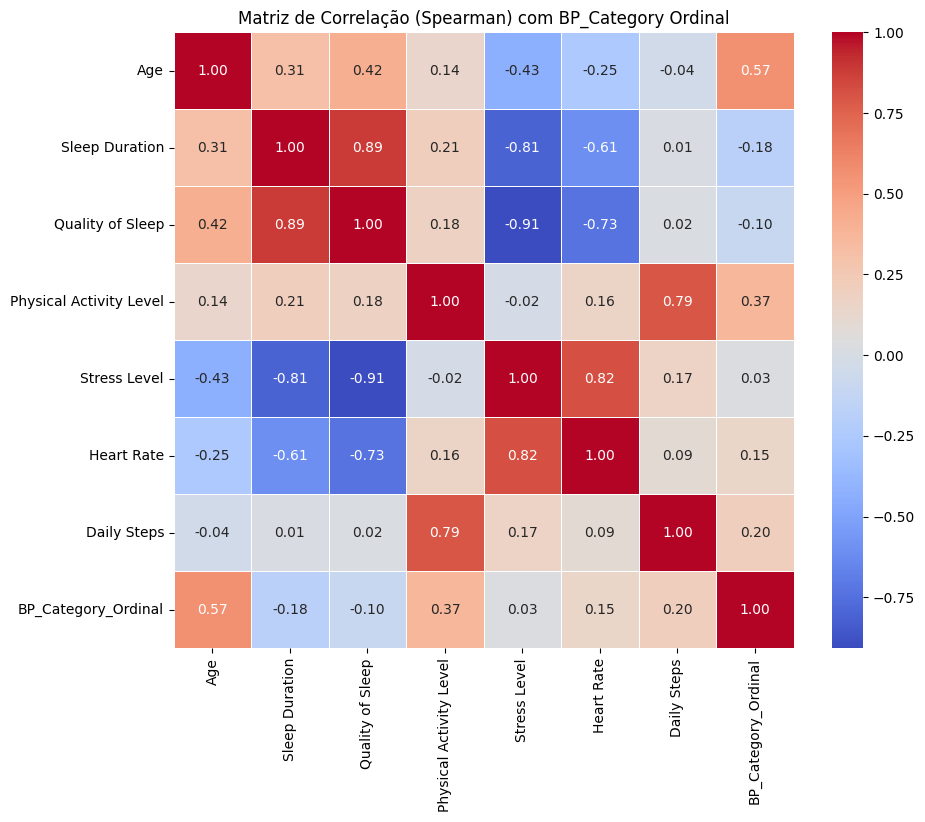

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

df_corr = df_clean.copy()

bp_order = {
    "Normal": 0,
    "Elevated": 1,
    "Hypertension_Stage1": 2,
    "Hypertension_Stage2": 3,
    "Hypertension_Stage3": 4
}

df_corr["BP_Category_Ordinal"] = df_corr["BP_Category"].map(bp_order)


num_df = df_corr.select_dtypes(include=["int64", "float64"])

if "HighRisk" in num_df.columns:
    num_df = num_df.drop(columns=["HighRisk"])

# Correlação de Spearman
corr_matrix = num_df.corr(method="spearman")

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5
)
plt.title("Matriz de Correlação (Spearman) com BP_Category Ordinal")
plt.show()


A análise da proporção de indivíduos em alto risco por categoria
permite identificar padrões relevantes entre variáveis categóricas e o risco de
hipertensão, além de possíveis vieses estruturais do dataset.

#### Gênero
Observa-se uma diferença expressiva entre os gêneros, com indivíduos do sexo
feminino apresentando maior proporção de alto risco em comparação aos do sexo
masculino. Essa associação pode refletir características específicas do dataset
ou fatores de confusão não explicitamente modelados, devendo ser interpretada
com cautela.

#### Ocupação
A variável `Occupation` apresenta grande variação na proporção de alto risco
entre categorias. No entanto, várias ocupações possuem **número muito reduzido
de observações**, o que pode inflar artificialmente a probabilidade estimada
(por exemplo, categorias com `n` muito pequeno).

Portanto, embora algumas ocupações aparentem alto ou baixo risco, essas associações
não devem ser interpretadas como conclusivas sem considerar o tamanho amostral
e possíveis efeitos de confusão.

#### Categoria de IMC (`BMI Category`)
A variável `BMI Category` apresenta um dos padrões mais claros da análise.
Observa-se um aumento progressivo da proporção de alto risco conforme o IMC aumenta,
com valores mais elevados nas categorias **Overweight** e **Obese**.

Esse comportamento está alinhado com evidências clínicas conhecidas, reforçando
a relevância do IMC como um fator associado ao risco de hipertensão.

#### Distúrbios do Sono (`Sleep Disorder`)
Indivíduos com **Sleep Apnea** apresentam uma proporção significativamente maior
de alto risco, enquanto aqueles sem distúrbios do sono (`No Disorder`) apresentam
valores substancialmente menores.

Esse resultado sugere uma forte associação entre distúrbios do sono e hipertensão,
coerente com achados da literatura médica, embora a análise permaneça estritamente
observacional.

---

#### Considerações Metodológicas

- As proporções apresentadas não implicam causalidade.
- Categorias com baixo número de observações devem ser interpretadas com cautela.
- Essa análise utiliza a variável `HighRisk` como **indicador auxiliar** e serve
  principalmente para exploração e geração de hipóteses.


In [17]:
# Proporção de HighRisk por categoria
cat_cols = df_clean.select_dtypes(include=["object"]).columns.tolist()
cat_cols = [c for c in cat_cols if c != "BP_Category"]

for col in cat_cols:
    print(f"\n--- {col} ---")
    summary = df_clean.groupby(col)["HighRisk"].agg(["mean", "count"]).sort_values("mean", ascending=False)
    summary = summary.rename(columns={"mean": "P(HighRisk=1)", "count": "n"})
    display(summary)



--- Gender ---


,P(HighRisk=1),n
Gender,,
Female,0.497297,185
Male,0.042328,189



--- Occupation ---


,P(HighRisk=1),n
Occupation,,
Sales Representative,1.000000,2
Nurse,0.890411,73
Teacher,0.700000,40
Software Engineer,0.250000,4
Doctor,0.056338,71
Engineer,0.000000,63
Accountant,0.000000,37
Lawyer,0.000000,47
Manager,0.000000,1



--- BMI Category ---


,P(HighRisk=1),n
BMI Category,,
Obese,0.800000,10
Overweight,0.621622,148
Normal Weight,0.000000,216



--- Sleep Disorder ---


,P(HighRisk=1),n
Sleep Disorder,,
Sleep Apnea,0.807692,78
Insomnia,0.389610,77
No Disorder,0.031963,219


### Idade por Gênero
Observa-se que indivíduos do sexo feminino apresentam idade média mais elevada
em comparação aos do sexo masculino.
Além disso, a distribuição etária feminina apresenta maior dispersão,
com valores máximos mais altos.

Esse desbalanceamento etário sugere que idade pode atuar como fator de confusão
em análises que envolvem gênero e risco de hipertensão, devendo ser considerada
nas interpretações subsequentes.

### Distribuição de IMC por Gênero
A distribuição das categorias de IMC difere significativamente entre os gêneros.
Enquanto indivíduos do sexo masculino concentram-se majoritariamente na categoria
**Normal Weight**, o sexo feminino apresenta maior proporção nas categorias
**Overweight** e **Obese**.

Esse padrão sugere que diferenças no perfil nutricional podem contribuir para
variações observadas no risco de hipertensão entre os gêneros.

### Interação entre Gênero, IMC e Risco de Hipertensão
A análise da taxa de `HighRisk` considerando simultaneamente gênero e IMC
indica que o risco elevado está concentrado em **combinações específicas**
dessas variáveis.

Em particular, observa-se:
- Maior taxa de alto risco em indivíduos do sexo feminino com sobrepeso
- Taxas elevadas em indivíduos do sexo masculino na categoria **Obese**

Entretanto, algumas combinações apresentam número reduzido de observações,
o que pode resultar em estimativas instáveis ou extremas (0 ou 1).
Assim, esses resultados devem ser interpretados como indícios exploratórios
e não como conclusões definitivas.

In [18]:
# Idade por gênero
df_clean.groupby("Gender")["Age"].describe()


,count,mean,std,min,25%,50%,75%,max
Gender,,,,,,,,
Female,185.0,47.405405,8.093407,29.0,39.0,50.0,53.0,59.0
Male,189.0,37.074074,5.662006,27.0,32.0,38.0,43.0,49.0


In [19]:
# Distribuição de BMI por gênero (contagem)
pd.crosstab(df_clean["Gender"], df_clean["BMI Category"], normalize="index")


BMI Category,Normal Weight,Obese,Overweight
Gender,,,
Female,0.421622,0.005405,0.572973
Male,0.730159,0.047619,0.222222


In [20]:
# Taxa de HighRisk por gênero e BMI (interação)
pd.pivot_table(
    df_clean,
    values="HighRisk",
    index="Gender",
    columns="BMI Category",
    aggfunc="mean"
)


BMI Category,Normal Weight,Obese,Overweight
Gender,,,
Female,0.0,0.000000,0.867925
Male,0.0,0.888889,0.000000


Observa-se que o risco cardiovascular no dataset está fortemente associado à categoria de IMC, com separação quase determinística quando combinada ao gênero. Isso sugere um viés estrutural na base de dados, possivelmente decorrente de regras de geração ou seleção dos registros, o que limita a generalização dos modelos para cenários reais.

## Definição Grupo de Features

In [21]:
def get_feature_groups():
    num_features = [...]
    ord_features = ["BMI Category"]
    nom_features = ["Gender", "Occupation", "Sleep Disorder"]
    bmi_order = ["Underweight", "Normal Weight", "Overweight", "Obese"]
    return num_features, ord_features, nom_features, bmi_order


# Salvar no Drive

In [22]:
import os
from google.colab import drive

drive.mount('/content/drive')

nome_da_pasta = "Ps Ligia Time 16"
caminho_base = "/content/drive/MyDrive/"
caminho_completo = os.path.join(caminho_base, nome_da_pasta)

if not os.path.exists(caminho_completo):
    os.makedirs(caminho_completo)
    print(f"Pasta '{nome_da_pasta}' criada com sucesso!")
else:
    print(f"A pasta '{nome_da_pasta}' já existe.")

# CSV base
caminho_arquivo_base = os.path.join(caminho_completo, "risco_cardiovascular_base.csv")
df_clean.to_csv(caminho_arquivo_base, index=False)

# CSV features adicionais
caminho_arquivo_base = os.path.join(caminho_completo, "risco_cardiovascular_features.csv")
df_features.to_csv(caminho_arquivo_base, index=False)

print(f"Dataset salvo em: {caminho_arquivo_base}")

Mounted at /content/drive
A pasta 'Ps Ligia Time 16' já existe.
Dataset salvo em: /content/drive/MyDrive/Ps Ligia Time 16/risco_cardiovascular_features.csv
